In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from collections import defaultdict
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import pickle
import json
import os

In [2]:
# Connect to MongoDB and load data
client = MongoClient('mongodb://localhost:27017/')
db = client['babyNameDB']
collection = db['babyNames']

In [3]:
# Retrieve data from MongoDB
data = list(collection.find({}, {'_id': 0}))
df = pd.DataFrame(data)
print(f"Loaded {len(df)} records from MongoDB.")
df.head()

Loaded 21612 records from MongoDB.


,Year of Birth,Gender,Ethnicity,First Name,Count,Rank
0,2011,FEMALE,HISPANIC,GERALDINE,13,75
1,2011,FEMALE,HISPANIC,GIA,21,67
2,2011,FEMALE,HISPANIC,GIANNA,49,42
3,2011,FEMALE,HISPANIC,GISELLE,38,51
4,2011,FEMALE,HISPANIC,GRACE,36,53


In [4]:
# Define Markov Chain Model
class MarkovChain:
    def __init__(self, order=2):
        self.order = order
        self.chain = defaultdict(lambda: defaultdict(int))
        self.start_tokens = defaultdict(int)

    def train(self, names):
        for name in names:
            tokens = ['<START>'] * self.order + list(name) + ['<END>']
            self.start_tokens[tuple(tokens[:self.order])] += 1
            for i in range(len(tokens) - self.order):
                state = tuple(tokens[i:i+self.order])
                next_char = tokens[i+self.order]
                self.chain[state][next_char] += 1

    def generate(self, min_length=3, max_length=12):
        state = self._weighted_choice(self.start_tokens)
        result = list(state)[1:]  # Remove the <START> token
        while True:
            next_char = self._weighted_choice(self.chain[state])
            if next_char == '<END>' or len(result) >= max_length:
                if len(result) >= min_length:
                    return ''.join(result)
                else:
                    return self.generate(min_length, max_length)
            result.append(next_char)
            state = state[1:] + (next_char,)

    def _weighted_choice(self, choices):
        total = sum(choices.values())
        r = np.random.rand() * total
        for choice, weight in choices.items():
            r -= weight
            if r <= 0:
                return choice

    def evaluate(self, test_names):
        total_prob = 0
        for name in test_names:
            prob = self.calculate_probability(name)
            total_prob += prob
        return total_prob / len(test_names)

    def calculate_probability(self, name):
        tokens = ['<START>'] * self.order + list(name) + ['<END>']
        prob = 1.0
        for i in range(len(tokens) - self.order):
            state = tuple(tokens[i:i+self.order])
            next_char = tokens[i+self.order]
            if state in self.chain and next_char in self.chain[state]:
                prob *= self.chain[state][next_char] / sum(self.chain[state].values())
            else:
                return 0
        return prob

    def to_dict(self):
        return {
            'order': self.order,
            'chain': {str(k): dict(v) for k, v in self.chain.items()},
            'start_tokens': {str(k): v for k, v in self.start_tokens.items()}
        }

    @classmethod
    def from_dict(cls, data):
        model = cls(data['order'])
        model.chain = defaultdict(lambda: defaultdict(int), {tuple(eval(k)): defaultdict(int, v) for k, v in data['chain'].items()})
        model.start_tokens = defaultdict(int, {tuple(eval(k)): v for k, v in data['start_tokens'].items()})
        return model
        
    # def to_json(self):
    #     return json.dumps({
    #         'order': self.order,
    #         'model': {str(k): v for k, v in self.model.items()}  # Convert tuple keys to strings
    #     })
    
    # @classmethod
    # def from_json(cls, json_str):
    #     data = json.loads(json_str)
    #     markov_chain = cls(data['order'])
    #     markov_chain.model = {tuple(eval(k)): v for k, v in data['model'].items()}  # Convert string keys back to tuples
    #     return markov_chain

In [5]:
# Function to train and evaluate models
def train_and_evaluate(df, group_columns=['Gender', 'Ethnicity'], order=2):
    results = []
    for group, group_df in df.groupby(group_columns):
        names = group_df['First Name'].tolist()
        train_names, test_names = train_test_split(names, test_size=0.2, random_state=42)

        model = MarkovChain(order=order)
        model.train(train_names)

        # Evaluate model
        performance = model.evaluate(test_names)

        results.append({
            'Group': group,
            'Model': model,
            'Performance': performance
        })

    return results

In [6]:
# Train and evaluate models
model_results = train_and_evaluate(df)

In [7]:
# Print results
for result in model_results:
    group = result['Group']
    performance = result['Performance']
    performance_percentage = performance * 100  # Convert to percentage

    print(f"Group: {group}, Performance: {performance:.4f}")
    print(f"The model for {group[0].lower()} {group[1].lower()} names has a performance of {performance_percentage:.4f}%, "
          f"meaning on average, it assigns a {performance_percentage:.4f}% probability to each name in the test set.")
    print()  # Add a blank line for readability between groups

Group: ('FEMALE', 'ASIAN AND PACIFIC ISLANDER'), Performance: 0.0004
The model for female asian and pacific islander names has a performance of 0.0426%, meaning on average, it assigns a 0.0426% probability to each name in the test set.

Group: ('FEMALE', 'BLACK NON HISPANIC'), Performance: 0.0005
The model for female black non hispanic names has a performance of 0.0505%, meaning on average, it assigns a 0.0505% probability to each name in the test set.

Group: ('FEMALE', 'HISPANIC'), Performance: 0.0003
The model for female hispanic names has a performance of 0.0270%, meaning on average, it assigns a 0.0270% probability to each name in the test set.

Group: ('FEMALE', 'WHITE NON HISPANIC'), Performance: 0.0002
The model for female white non hispanic names has a performance of 0.0196%, meaning on average, it assigns a 0.0196% probability to each name in the test set.

Group: ('MALE', 'ASIAN AND PACIFIC ISLANDER'), Performance: 0.0005
The model for male asian and pacific islander names h

In [8]:
# Calculate overall performance
overall_performance = np.mean([result['Performance'] for result in model_results])
overall_performance_percentage = overall_performance * 100  # Convert to percentage

print(f"\nOverall Model Performance: {overall_performance:.4f}")
print(f"The overall model has a performance of {overall_performance_percentage:.4f}%, "
      f"meaning on average across all groups, it assigns a {overall_performance_percentage:.4f}% "
      f"probability to each name in the test sets.")


Overall Model Performance: 0.0003
The overall model has a performance of 0.0330%, meaning on average across all groups, it assigns a 0.0330% probability to each name in the test sets.


In [9]:
# Model Optimization
def optimize_model(df, group_columns=['Gender', 'Ethnicity'], orders=[1, 2, 3]):
    optimization_results = []
    for order in orders:
        print(f"Training models with order {order}...")
        results = train_and_evaluate(df, group_columns, order)
        overall_performance = np.mean([result['Performance'] for result in results])
        optimization_results.append({
            'Order': order,
            'Overall Performance': overall_performance,
            'Results': results
        })
        print(f"Order {order} - Overall Performance: {overall_performance:.4f}")
    
    return optimization_results

optimization_results = optimize_model(df)

Training models with order 1...
Order 1 - Overall Performance: 0.0000
Training models with order 2...
Order 2 - Overall Performance: 0.0003
Training models with order 3...
Order 3 - Overall Performance: 0.0018


In [10]:
# Find the best model
best_model = max(optimization_results, key=lambda x: x['Overall Performance'])
print(f"\nBest Model - Order: {best_model['Order']}, Performance: {best_model['Overall Performance']:.4f}")


Best Model - Order: 3, Performance: 0.0018


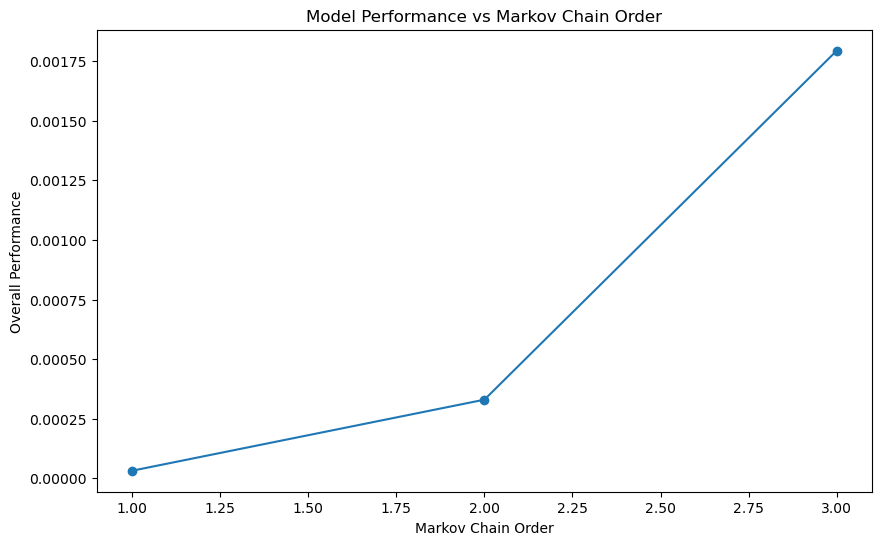

In [11]:
# Plot optimization results
plt.figure(figsize=(10, 6))
plt.plot([r['Order'] for r in optimization_results], [r['Overall Performance'] for r in optimization_results], marker='o')
plt.xlabel('Markov Chain Order')
plt.ylabel('Overall Performance')
plt.title('Model Performance vs Markov Chain Order')
plt.show()

In [12]:
# Generate Sample Names
def generate_sample_names(model_results, num_samples=5, min_length=3, max_length=12):
    for result in model_results:
        print(f"\nGroup: {result['Group']}")
        for _ in range(num_samples):
            # Generate a random length between min_length and max_length
            name_length = random.randint(min_length, max_length)
            generated_name = result['Model'].generate(name_length)
            # Convert the generated name to all uppercase
            generated_name = generated_name.upper()
            print(f"  {generated_name}")

generate_sample_names(best_model['Results'])


Group: ('FEMALE', 'ASIAN AND PACIFIC ISLANDER')
  <START><START>NICOLE
  <START><START>HANISHA
  <START><START>ALINA
  <START><START>PENE
  <START><START>CAROLIVIAN

Group: ('FEMALE', 'BLACK NON HISPANIC')
  <START><START>MICHELSEA
  <START><START>AISSATOUMA
  <START><START>CHLOE
  <START><START>JASMINE
  <START><START>LAUREN

Group: ('FEMALE', 'HISPANIC')
  <START><START>VALEYLAH
  <START><START>JAYLEN
  <START><START>ESTHERINE
  <START><START>ZOEY
  <START><START>ARIANALIA

Group: ('FEMALE', 'WHITE NON HISPANIC')
  <START><START>LINA
  <START><START>VALESSANDA
  <START><START>DANISA
  <START><START>NORAH
  <START><START>FATILDA

Group: ('MALE', 'ASIAN AND PACIFIC ISLANDER')
  <START><START>IBRANDREW
  <START><START>MILES
  <START><START>ROHAMMED
  <START><START>PRESTOPHER
  <START><START>AHMAD

Group: ('MALE', 'BLACK NON HISPANIC')
  <START><START>MAVERY
  <START><START>AYDEN
  <START><START>JAIDEN
  <START><START>JERMIAH
  <START><START>ALEXANDREW

Group: ('MALE', 'HISPANIC')
  <ST

In [13]:
def save_models(models, filename='markov_trained.json'):
    serialized_models = {f"{gender}_{ethnicity}": model.to_dict() for (gender, ethnicity), model in models.items()}
    with open(filename, 'w') as f:
        json.dump(serialized_models, f)

In [14]:
# Create a dictionary to store the models
baby_name_models = {}
for result in best_model['Results']:
    gender, ethnicity = result['Group']
    model = result['Model']
    baby_name_models[(gender, ethnicity)] = model

# Save the models
save_models(baby_name_models, 'markov_trained.json')
print("Models saved successfully.")

Models saved successfully.
